In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.linear_model import LogisticRegression
from itertools import combinations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Load Model Evaluation Results on Static Benchmark Questions

In [2]:
static_df = pd.read_csv("./data/static_10_models.csv")
len(static_df)
# arena_data = load_dataset("lmarena-ai/arena-human-preference-140k")['train']

5000

In [3]:
static_df.head(10)

,question_id,question,model_name,correct_answer,model_answer,judge_result,level
0,GSM-8k_1,Janet’s ducks lay 16 eggs per day. She eats th...,claude-3-5-haiku-20241022,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,Let's solve this step by step:\n1. Total eggs ...,1,NaN
1,GSM-8k_1,Janet’s ducks lay 16 eggs per day. She eats th...,gemini-2.0-flash,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,$18,1,NaN
2,GSM-8k_1,Janet’s ducks lay 16 eggs per day. She eats th...,gpt-4o-mini,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,"Janet has 16 eggs, eats 3, and uses 4 for baki...",1,NaN
3,GSM-8k_1,Janet’s ducks lay 16 eggs per day. She eats th...,grok-3-mini-beta,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,Janet's ducks lay 16 eggs per day. She uses 3 ...,1,NaN
4,GSM-8k_1,Janet’s ducks lay 16 eggs per day. She eats th...,llama-3.3-70b-it,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,$18,1,NaN
5,GSM-8k_1,Janet’s ducks lay 16 eggs per day. She eats th...,gpt-4.1-mini-2025-04-14,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,Janet makes $18 every day at the farmers' market.,1,NaN
6,GSM-8k_1,Janet’s ducks lay 16 eggs per day. She eats th...,claude-3-7-sonnet-20250219,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,$18,1,NaN
7,GSM-8k_1,Janet’s ducks lay 16 eggs per day. She eats th...,gemma-3-27b-it,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,26,0,NaN
8,GSM-8k_1,Janet’s ducks lay 16 eggs per day. She eats th...,deepseek-v3-0324,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,18,1,NaN
9,GSM-8k_1,Janet’s ducks lay 16 eggs per day. She eats th...,mistral-medium-2505,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,Janet makes $18 every day at the farmers' market.,1,NaN


# Static Baseline: Ranking Item-level Difficulty Based on Number of Correct Models

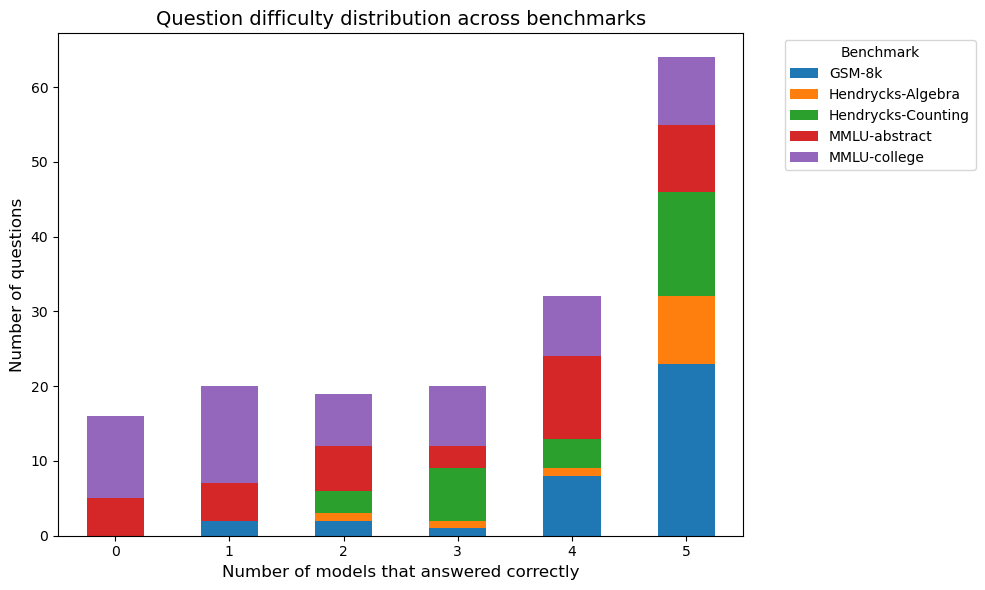

In [4]:
difficulty_df = (
    static_df.groupby("question_id")["judge_result"]
    .agg(num_correct="sum", num_attempts="count")
    .reset_index()
)

difficulty_df["benchmark"] = difficulty_df["question_id"].str.rsplit("_", n=1).str[0]

count_df = (
    difficulty_df.groupby(["num_correct", "benchmark"])
    .size()
    .unstack(fill_value=0)
    .reindex(range(6), fill_value=0) 
)

count_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
)

plt.xlabel("Number of models that answered correctly", fontsize=12)
plt.ylabel("Number of questions", fontsize=12)
plt.title("Question difficulty distribution across benchmarks", fontsize=14)
plt.xticks(rotation=0)  
plt.legend(title="Benchmark", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
# plt.savefig("./figures/naive_ranking.pdf", dpi=500)
plt.show()

In [5]:
static_naive_ranking = difficulty_df.sort_values(by="num_correct").copy()
static_naive_ranking

,question_id,num_correct,num_attempts,benchmark
368,MMLU-abstract_7,0,10,MMLU-abstract
360,MMLU-abstract_62,0,10,MMLU-abstract
459,MMLU-college_62,0,10,MMLU-college
462,MMLU-college_65,0,10,MMLU-college
429,MMLU-college_35,0,10,MMLU-college
...,...,...,...,...
478,MMLU-college_8,10,10,MMLU-college
54,GSM-8k_56,10,10,GSM-8k
46,GSM-8k_49,10,10,GSM-8k
20,GSM-8k_25,10,10,GSM-8k


# 2-Parameter Logistic IRT for Static Benchmark Questions

In [7]:
def fit_2pl_irt(
    static_df: pd.DataFrame,
    num_epochs: int = 2000,
    lr: float = 0.05,
    reg_lambda: float = 1e-4,
    verbose: bool = False,
):
    """
    Fit a 2-parameter IRT (2PL) model using simple gradient descent in PyTorch.

    Model:
        logit P(correct_{i,q}) = a_q * (theta_i - b_q)
        where a_q = exp(k_q) > 0 is the discrimination of question q.

    Parameters
    ----------
    static_df : DataFrame
        Must contain columns:
          - 'model_name'
          - 'question_id'
          - 'judge_result' (0/1 correctness)
    num_epochs : int
        Number of training epochs.
    lr : float
        Learning rate.
    reg_lambda : float
        L2 regularization strength on theta, b, k.
    verbose : bool
        If True, prints training loss every 500 epochs.

    Returns
    -------
    model_ranking : DataFrame
        columns: ['model_name', 'theta'], sorted descending by theta.
    question_ranking : DataFrame
        columns: ['question_id', 'difficulty_b', 'k_raw', 'discrimination_a'],
                 sorted descending by difficulty_b (higher = harder).
    """
    df = static_df.copy()

    # 1) Encode models and questions as categorical indices
    df["model_cat"] = df["model_name"].astype("category")
    df["question_cat"] = df["question_id"].astype("category")

    df["model_idx"] = df["model_cat"].cat.codes
    df["question_idx"] = df["question_cat"].cat.codes

    n_models = df["model_idx"].nunique()
    n_questions = df["question_idx"].nunique()

    # 2) Build index tensors and labels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    m_idx = torch.tensor(df["model_idx"].values, dtype=torch.long, device=device)
    q_idx = torch.tensor(df["question_idx"].values, dtype=torch.long, device=device)
    y = torch.tensor(df["judge_result"].values, dtype=torch.float32, device=device)

    # 3) Parameters:
    #    theta_i: ability per model
    #    b_q: difficulty per question
    #    k_q: log-discrimination per question, a_q = exp(k_q)
    theta = nn.Embedding(n_models, 1, device=device)
    b = nn.Embedding(n_questions, 1, device=device)
    k = nn.Embedding(n_questions, 1, device=device)

    # Initialize close to zero
    nn.init.zeros_(theta.weight)
    nn.init.zeros_(b.weight)
    nn.init.zeros_(k.weight)

    optimizer = optim.Adam(
        list(theta.parameters()) + list(b.parameters()) + list(k.parameters()),
        lr=lr,
    )
    bce = nn.BCEWithLogitsLoss()

    # 4) Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        theta_i = theta(m_idx).squeeze(-1)      # [N]
        b_q = b(q_idx).squeeze(-1)              # [N]
        k_q = k(q_idx).squeeze(-1)              # [N]
        a_q = torch.exp(k_q)                    # discrimination > 0

        # 2PL logits: a_q * (theta_i - b_q)
        logits = a_q * (theta_i - b_q)

        loss_main = bce(logits, y)

        # L2 regularization on all parameters
        reg = reg_lambda * (
            theta.weight.pow(2).mean()
            + b.weight.pow(2).mean()
            + k.weight.pow(2).mean()
        )

        loss = loss_main + reg
        loss.backward()
        optimizer.step()

        # Identifiability: enforce mean(theta) = 0, shift b accordingly
        with torch.no_grad():
            theta_mean = theta.weight.mean()
            theta.weight.sub_(theta_mean)
            b.weight.sub_(theta_mean)

        if verbose and (epoch % 500 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch:4d} | loss = {loss.item():.4f}")

    # 5) Extract parameters
    theta_np = theta.weight.detach().cpu().numpy().squeeze(-1)
    b_np = b.weight.detach().cpu().numpy().squeeze(-1)
    k_np = k.weight.detach().cpu().numpy().squeeze(-1)
    a_np = np.exp(k_np)

    model_levels = df["model_cat"].cat.categories
    question_levels = df["question_cat"].cat.categories

    model_ranking = (
        pd.DataFrame({"model_name": model_levels, "theta": theta_np})
        .sort_values("theta", ascending=False)
        .reset_index(drop=True)
    )

    question_ranking = (
        pd.DataFrame(
            {
                "question_id": question_levels,
                "difficulty_b": b_np,
                "k_raw": k_np,
                "discrimination_a": a_np,
            }
        )
        .sort_values("difficulty_b", ascending=False)  # higher = harder
        .reset_index(drop=True)
    )

    return model_ranking, question_ranking

# Plotting Function

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_difficulty_and_ability(
    model_ranking,
    question_ranking,
    bins: int = 40,
    save_path: str | None = None,
    save: bool = False,
    title: str | None = None,
):
    """
    Stacked histogram of question difficulties (optionally by benchmark)
    with model abilities overlaid.

    Assumes:
      - model_ranking: DataFrame with columns ["model_name", "theta"]
      - question_ranking: DataFrame with columns ["question_id", "difficulty_b"]
        and optionally "benchmark".
        If "benchmark" is missing, all questions are treated as a single group.
    """
    qr = question_ranking.copy()

    # --- handle benchmark column more robustly ---
    if "benchmark" not in qr.columns:
        # Try to infer from question_id if it looks like "<bench>_<something>"
        qid_str = qr["question_id"].astype(str)
        if qid_str.str.contains("_").any():
            qr["benchmark"] = qid_str.str.rsplit("_", n=1).str[0]
        else:
            qr["benchmark"] = "All questions"

    benchmarks = sorted(qr["benchmark"].unique())
    bench_colors = plt.cm.tab10.colors[: len(benchmarks)]

    fig, ax = plt.subplots(figsize=(10, 5))

    # ----- stacked histogram of difficulties -----
    b_vals = qr["difficulty_b"].values
    if len(b_vals) == 0:
        raise ValueError("question_ranking appears to be empty.")

    bin_edges = np.linspace(b_vals.min(), b_vals.max(), bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = np.diff(bin_edges)

    hist_data = []
    for bmk in benchmarks:
        vals = qr.loc[qr["benchmark"] == bmk, "difficulty_b"].values
        hist, _ = np.histogram(vals, bins=bin_edges)
        hist_data.append(hist)
    hist_data = np.array(hist_data)

    bottoms = np.zeros_like(hist_data[0])
    bench_handles = []
    for i, bmk in enumerate(benchmarks):
        ax.bar(
            bin_centers,
            hist_data[i],
            width=bin_widths,
            bottom=bottoms,
            color=bench_colors[i],
            alpha=0.8,
            align="center",
            edgecolor="white",
        )
        bottoms += hist_data[i]
        bench_handles.append(Line2D([0], [0], color=bench_colors[i], lw=6, label=bmk))

    y_max = bottoms.max() if len(bottoms) > 0 else 1.0
    ax.set_ylim(0, max(1.0, y_max * 1.6))

    # ----- overlay model abilities -----
    mr_sorted = model_ranking.sort_values("theta", ascending=False).reset_index(drop=True)
    theta_vals = mr_sorted["theta"].values
    model_names = mr_sorted["model_name"].values

    # nice rank labels: 1st, 2nd, 3rd, 4th, ...
    suffix = lambda i: "st" if i == 0 else "nd" if i == 1 else "rd" if i == 2 else "th"
    rank_labels = [f"{i+1}{suffix(i)}" for i in range(len(model_names))]

    model_colors = plt.cm.Dark2.colors[: len(model_names)]
    model_handles = []

    # where to draw markers vertically
    vline_top = y_max * 1.05 / (max(1.0, y_max * 1.6))
    marker_y = y_max * 1.1
    text_y = y_max * 1.2

    for i, (theta, name) in enumerate(zip(theta_vals, model_names)):
        color = model_colors[i % len(model_colors)]
        ax.axvline(
            theta,
            0,
            vline_top,
            color=color,
            linestyle="--",
            linewidth=1.5,
            alpha=0.9,
        )
        ax.scatter([theta], [marker_y], color=color, s=60, zorder=5)
        ax.text(
            theta,
            text_y,
            rank_labels[i],
            ha="center",
            va="bottom",
            fontsize=9,
            color=color,
            fontweight="medium",
        )
        model_handles.append(
            Line2D(
                [0],
                [0],
                color=color,
                linestyle="--",
                marker="o",
                markersize=6,
                label=f"{rank_labels[i]}: {name}",
            )
        )

    # ----- cosmetics & legends -----
    ax.set_xlabel("Latent scale (ability $\\theta$ / difficulty $b$)")
    ax.set_ylabel("Number of questions")

    if title is None:
        title = "Question difficulty distribution across benchmarks\nwith model abilities overlaid"
    ax.set_title(title)

    # legend for benchmarks
    if len(benchmarks) > 1 or benchmarks[0] != "All questions":
        legend1 = ax.legend(
            handles=bench_handles,
            title="Benchmarks",
            frameon=False,
            bbox_to_anchor=(1.02, 1),
            loc="upper left",
        )
        ax.add_artist(legend1)

    # legend for models
    ax.legend(
        handles=model_handles,
        title="Models",
        frameon=False,
        bbox_to_anchor=(1.02, 0.45),
        loc="upper left",
    )

    plt.tight_layout(rect=[0, 0, 1, 0.9])

    if save_path is not None and save:
        plt.savefig(save_path, dpi=500)

    plt.show()


Epoch    0 | loss = 0.6931
Epoch  500 | loss = 0.3435
Epoch 1000 | loss = 0.3397
Epoch 1500 | loss = 0.3440
Epoch 1999 | loss = 0.3376


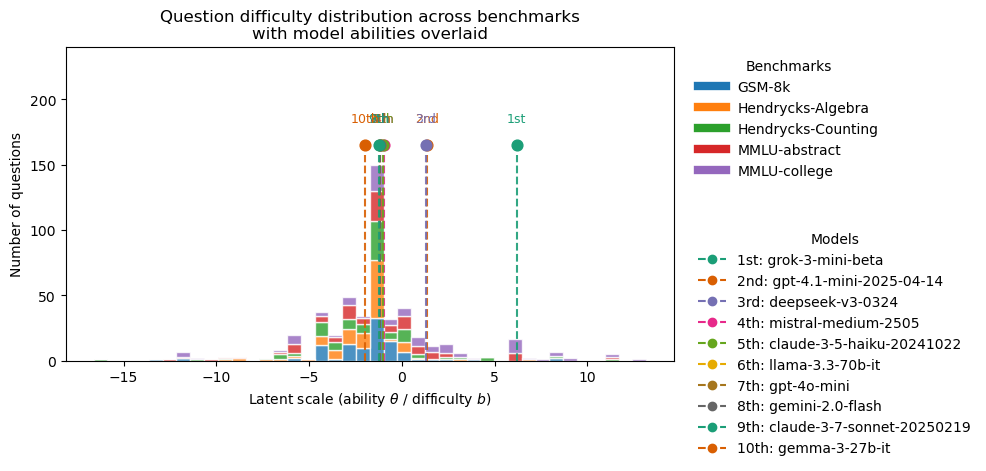

In [9]:
model_ranking, question_ranking = fit_2pl_irt(static_df, verbose=True)
plot_difficulty_and_ability(model_ranking, question_ranking, save_path="./figures/static_2pl_ranking.pdf", save=False)

# Our Unified Ranking Algorithm: Using Static Data to Simulate the Arena Setting

In [10]:
def build_pairwise_from_static(static_df: pd.DataFrame) -> pd.DataFrame:
    """
    From per-(model, question) correctness labels,
    build a pairwise dataset with outcomes:
      - m1_win  (model_1 correct, model_2 wrong)
      - m2_win  (model_1 wrong, model_2 correct)
      - tie     (both correct)
      - both_bad (both wrong)
    """
    rows = []
    for qid, group in static_df.groupby("question_id"):
        # all unordered model pairs for this question
        for (_, r1), (_, r2) in combinations(group.iterrows(), 2):
            m1, m2 = r1["model_name"], r2["model_name"]
            y1, y2 = r1["judge_result"], r2["judge_result"]

            if y1 == 1 and y2 == 0:
                outcome = "m1_win"
            elif y1 == 0 and y2 == 1:
                outcome = "m2_win"
            elif y1 == 1 and y2 == 1:
                outcome = "tie"
            else:
                outcome = "both_bad"

            rows.append(
                {
                    "question_id": qid,
                    "model_1": m1,
                    "model_2": m2,
                    "outcome": outcome,
                }
            )
    return pd.DataFrame(rows)

def fit_pairwise_arena_model(
    static_df: pd.DataFrame,
    num_epochs: int = 2000,
    lr: float = 0.05,
    verbose: bool = True,
):
    """
    Fit the model:
      pi_{i,q} = sigmoid(theta_i - b_q)
      P(m_i > m_j | q) = sigmoid(exp(k_q) * (pi_{i,q} - pi_{j,q}))
    using only decisive pairs (m1_win / m2_win).
    Returns DataFrames for model parameters and question parameters.
    """
    # 2.1 Build pairwise data and keep only win/loss pairs
    pairwise_df = build_pairwise_from_static(static_df)
    train_pairs = pairwise_df[pairwise_df["outcome"].isin(["m1_win", "m2_win"])].copy()

    # Binary label: 1 if model_1 wins, 0 if model_2 wins
    train_pairs["label"] = (train_pairs["outcome"] == "m1_win").astype(float)

    # 2.2 Index models and questions
    model_ids = pd.Index(pd.unique(static_df["model_name"]), name="model_name")
    question_ids = pd.Index(pd.unique(static_df["question_id"]), name="question_id")

    model_to_idx = {m: i for i, m in enumerate(model_ids)}
    q_to_idx = {q: i for i, q in enumerate(question_ids)}

    train_pairs["model_1_idx"] = train_pairs["model_1"].map(model_to_idx)
    train_pairs["model_2_idx"] = train_pairs["model_2"].map(model_to_idx)
    train_pairs["question_idx"] = train_pairs["question_id"].map(q_to_idx)

    m1_idx = torch.tensor(train_pairs["model_1_idx"].values, dtype=torch.long)
    m2_idx = torch.tensor(train_pairs["model_2_idx"].values, dtype=torch.long)
    q_idx = torch.tensor(train_pairs["question_idx"].values, dtype=torch.long)
    y = torch.tensor(train_pairs["label"].values, dtype=torch.float32)

    n_models = len(model_ids)
    n_questions = len(question_ids)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    m1_idx = m1_idx.to(device)
    m2_idx = m2_idx.to(device)
    q_idx = q_idx.to(device)
    y = y.to(device)

    # 2.3 Parameters:
    #   theta_i: ability per model
    #   b_q: difficulty per question
    #   k_q: unconstrained discrimination per question, exp(k_q) > 0
    theta = nn.Embedding(n_models, 1, device=device)
    b = nn.Embedding(n_questions, 1, device=device)
    k = nn.Embedding(n_questions, 1, device=device)

    nn.init.zeros_(theta.weight)
    nn.init.zeros_(b.weight)
    nn.init.zeros_(k.weight)

    params = list(theta.parameters()) + list(b.parameters()) + list(k.parameters())
    optimizer = optim.Adam(params, lr=lr)

    bce = nn.BCEWithLogitsLoss()  

    # 2.4 Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        theta_m1 = theta(m1_idx).squeeze(-1)  # [N]
        theta_m2 = theta(m2_idx).squeeze(-1)  # [N]
        b_q = b(q_idx).squeeze(-1)            # [N]
        k_q = k(q_idx).squeeze(-1)            # [N]

        # latent satisfaction probabilities
        pi_m1 = torch.sigmoid(theta_m1 - b_q)  # pi_{i,q}
        pi_m2 = torch.sigmoid(theta_m2 - b_q)  # pi_{j,q}

        # discrimination: exp(k_q) > 0
        disc_q = torch.exp(k_q)

        # logits for P(m1 > m2 | q) = sigmoid(exp(k_q) * (pi_m1 - pi_m2))
        logits = disc_q * (pi_m1 - pi_m2)

        loss_main = bce(logits, y)

        # small L2 regularization to stabilize scale
        reg = 1e-4 * (
            theta.weight.pow(2).mean()
            + b.weight.pow(2).mean()
            + k.weight.pow(2).mean()
        )

        total_loss = loss_main + reg
        total_loss.backward()
        optimizer.step()

        # identifiability: enforce mean-zero on theta, shift b accordingly.
        with torch.no_grad():
            theta_mean = theta.weight.mean()
            theta.weight.sub_(theta_mean)
            b.weight.sub_(theta_mean)

        if verbose and (epoch % 500 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch:4d} | loss = {total_loss.item():.4f}")

    # 2.5 Extract parameters
    theta_np = theta.weight.detach().cpu().numpy().squeeze(-1)
    b_np = b.weight.detach().cpu().numpy().squeeze(-1)
    k_np = k.weight.detach().cpu().numpy().squeeze(-1)
    disc_np = (torch.exp(k.weight).detach().cpu().numpy().squeeze(-1))

    model_params = pd.DataFrame(
        {
            "model_name": model_ids,
            "theta": theta_np,
        }
    ).sort_values("theta", ascending=False)

    question_params = pd.DataFrame(
        {
            "question_id": question_ids,
            "difficulty_b": b_np,       # higher = harder
            "k_raw": k_np,
            "discrimination_exp_k": disc_np,
        }
    ).sort_values("difficulty_b", ascending=False)

    return model_params, question_params

In [11]:
def pairwise_IRT(
    static_df: pd.DataFrame,
    num_epochs: int = 2000,
    lr: float = 0.01,
    lambda_tie: float = 0.0,
    lambda_bb: float = 0.3,
    verbose: bool = True,
):
    """
    Extended pairwise IRT model:
      pi_{i,q} = sigmoid(theta_i - b_q)
      a_q = exp(k_q)
      z_{ijq} = a_q * (pi_{i,q} - pi_{j,q})
      P(i > j | q) = sigmoid(z_{ijq})

    Supports 4 outcomes:
      m1_win:     model_1 preferred
      m2_win:     model_2 preferred
      tie:        equal quality (target p = 0.5)
      both_bad:   both responses incorrect (absolute correctness constraint)
    """

    # -----------------------------------------------------
    # Step 1: Construct pairwise outcomes
    # -----------------------------------------------------
    pairwise_df = build_pairwise_from_static(static_df)

    # Identify different subsets
    df_win  = pairwise_df[pairwise_df["outcome"] == "m1_win"].copy()
    df_loss = pairwise_df[pairwise_df["outcome"] == "m2_win"].copy()
    df_tie  = pairwise_df[pairwise_df["outcome"] == "tie"].copy()
    df_bb   = pairwise_df[pairwise_df["outcome"] == "both_bad"].copy()

    # Add binary labels for decisive pairs:
    # label = 1 for m1_win, 0 for m2_win
    df_win["label"]  = 1.0
    df_loss["label"] = 0.0
    df_dec = pd.concat([df_win, df_loss], axis=0)

    # -----------------------------------------------------
    # Step 2: Index models & questions
    # -----------------------------------------------------
    model_ids = pd.Index(pd.unique(static_df["model_name"]), name="model_name")
    question_ids = pd.Index(pd.unique(static_df["question_id"]), name="question_id")

    model_to_idx = {m: i for i, m in enumerate(model_ids)}
    q_to_idx = {q: i for i, q in enumerate(question_ids)}

    def map_indices(df):
        df["m1_idx"] = df["model_1"].map(model_to_idx)
        df["m2_idx"] = df["model_2"].map(model_to_idx)
        df["q_idx"]  = df["question_id"].map(q_to_idx)
        return df

    df_dec = map_indices(df_dec)
    df_tie = map_indices(df_tie)
    df_bb  = map_indices(df_bb)

    # Convert to tensors
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Decisive
    m1_dec = torch.tensor(df_dec["m1_idx"].values).long().to(device)
    m2_dec = torch.tensor(df_dec["m2_idx"].values).long().to(device)
    q_dec  = torch.tensor(df_dec["q_idx"].values).long().to(device)
    y_dec  = torch.tensor(df_dec["label"].values).float().to(device)

    # Ties
    m1_tie = torch.tensor(df_tie["m1_idx"].values).long().to(device)
    m2_tie = torch.tensor(df_tie["m2_idx"].values).long().to(device)
    q_tie  = torch.tensor(df_tie["q_idx"].values).long().to(device)

    # Both_bad
    m1_bb = torch.tensor(df_bb["m1_idx"].values).long().to(device)
    m2_bb = torch.tensor(df_bb["m2_idx"].values).long().to(device)
    q_bb  = torch.tensor(df_bb["q_idx"].values).long().to(device)

    n_models = len(model_ids)
    n_questions = len(question_ids)

    # -----------------------------------------------------
    # Step 3: Parameters (theta, b, k)
    # -----------------------------------------------------
    theta = nn.Embedding(n_models, 1, device=device)
    b     = nn.Embedding(n_questions, 1, device=device)
    k     = nn.Embedding(n_questions, 1, device=device)

    nn.init.zeros_(theta.weight)
    nn.init.zeros_(b.weight)
    nn.init.zeros_(k.weight)

    optimizer = torch.optim.Adam(
        list(theta.parameters()) + list(b.parameters()) + list(k.parameters()),
        lr=lr
    )

    bce = nn.BCEWithLogitsLoss()

    # -----------------------------------------------------
    # Step 4: Training loop
    # -----------------------------------------------------
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # ------------------------------
        # Decisive pairs: win/loss
        # ------------------------------
        theta_m1 = theta(m1_dec).squeeze(-1)
        theta_m2 = theta(m2_dec).squeeze(-1)
        b_q_dec  = b(q_dec).squeeze(-1)
        k_q_dec  = k(q_dec).squeeze(-1)

        pi_m1 = torch.sigmoid(theta_m1 - b_q_dec)
        pi_m2 = torch.sigmoid(theta_m2 - b_q_dec)
        a_q   = torch.exp(k_q_dec)

        z_dec = a_q * (pi_m1 - pi_m2)
        loss_dec = bce(z_dec, y_dec)

        # ------------------------------
        # Tie pairs: soft target 0.5
        # ------------------------------
        if len(df_tie) > 0:
            theta_m1_tie = theta(m1_tie).squeeze(-1)
            theta_m2_tie = theta(m2_tie).squeeze(-1)
            b_q_tie      = b(q_tie).squeeze(-1)
            k_q_tie      = k(q_tie).squeeze(-1)

            pi_m1_t = torch.sigmoid(theta_m1_tie - b_q_tie)
            pi_m2_t = torch.sigmoid(theta_m2_tie - b_q_tie)
            a_q_t   = torch.exp(k_q_tie)

            z_tie = a_q_t * (pi_m1_t - pi_m2_t)
            y_tie = torch.full_like(z_tie, 0.5)
            loss_tie = bce(z_tie, y_tie)
        else:
            loss_tie = torch.tensor(0.0, device=device)

        # ------------------------------
        # Both-bad pairs: absolute correctness
        # ------------------------------
        if len(df_bb) > 0:
            theta_m1_bb = theta(m1_bb).squeeze(-1)
            theta_m2_bb = theta(m2_bb).squeeze(-1)
            b_q_bb      = b(q_bb).squeeze(-1)

            pi_m1_bb = torch.sigmoid(theta_m1_bb - b_q_bb)
            pi_m2_bb = torch.sigmoid(theta_m2_bb - b_q_bb)

            # -log(1 - pi_i) - log(1 - pi_j)
            loss_bb = -torch.log(1 - pi_m1_bb + 1e-6).mean() \
                      -torch.log(1 - pi_m2_bb + 1e-6).mean()
        else:
            loss_bb = torch.tensor(0.0, device=device)

        # ------------------------------
        # L2 regularization
        # ------------------------------
        reg = 1e-4 * (
            theta.weight.pow(2).mean()
            + b.weight.pow(2).mean()
        ) + 1e-3 * k.weight.pow(2).mean()

        # Total loss
        total_loss = loss_dec + lambda_tie * loss_tie + lambda_bb * loss_bb + reg
        total_loss.backward()
        optimizer.step()

        # ------------------------------
        # Identifiability: mean(θ) = 0
        # ------------------------------
        with torch.no_grad():
            shift = theta.weight.mean()
            theta.weight.sub_(shift)
            b.weight.sub_(shift)

        if verbose and (epoch % 500 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch:4d} | "
                  f"dec={loss_dec.item():.4f}  "
                  # f"tie={loss_tie.item():.4f}  "
                  f"bb={loss_bb.item():.4f}  "
                  f"total={total_loss.item():.4f}")

    # -----------------------------------------------------
    # Step 5: Extract & return parameters
    # -----------------------------------------------------
    theta_np = theta.weight.detach().cpu().numpy().squeeze(-1)
    b_np     = b.weight.detach().cpu().numpy().squeeze(-1)
    k_np     = k.weight.detach().cpu().numpy().squeeze(-1)
    disc_np  = np.exp(k_np)

    model_params = pd.DataFrame({
        "model_name": model_ids,
        "theta": theta_np,
    }).sort_values("theta", ascending=False)

    question_params = pd.DataFrame({
        "question_id": question_ids,
        "difficulty_b": b_np,
        "k_raw": k_np,
        "discrimination_exp_k": disc_np,
    }).sort_values("difficulty_b", ascending=False)

    return model_params, question_params

In [12]:
model_ranking, question_ranking = pairwise_IRT(static_df, num_epochs=5000, lr=0.03)

print("Model abilities:")
print(model_ranking)

print("\nQuestion difficulty ranking (higher = harder):")
print(question_ranking.head(20))

Epoch    0 | dec=0.6931  bb=1.3863  total=1.1090
Epoch  500 | dec=0.3695  bb=0.0287  total=0.3940
Epoch 1000 | dec=0.3606  bb=0.0213  total=0.3835
Epoch 1500 | dec=0.3545  bb=0.0169  total=0.3766
Epoch 2000 | dec=0.3505  bb=0.0142  total=0.3722
Epoch 2500 | dec=0.3479  bb=0.0124  total=0.3699
Epoch 3000 | dec=0.3463  bb=0.0112  total=0.3688
Epoch 3500 | dec=0.3454  bb=0.0105  total=0.3684
Epoch 4000 | dec=0.3450  bb=0.0102  total=0.3683
Epoch 4500 | dec=0.3448  bb=0.0099  total=0.3682
Epoch 4999 | dec=0.3448  bb=0.0099  total=0.3682
Model abilities:
                   model_name      theta
3            grok-3-mini-beta  12.707070
5     gpt-4.1-mini-2025-04-14   7.712531
8            deepseek-v3-0324   3.813145
9         mistral-medium-2505  -0.127977
0   claude-3-5-haiku-20241022  -3.388325
4            llama-3.3-70b-it  -3.543829
2                 gpt-4o-mini  -3.553636
1            gemini-2.0-flash  -3.578484
6  claude-3-7-sonnet-20250219  -3.587486
7              gemma-3-27b-it  -6.

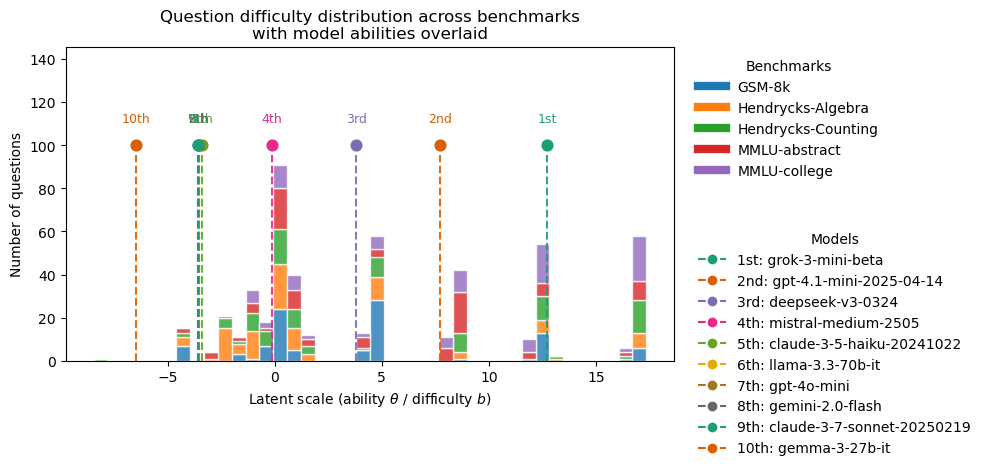

In [13]:
plot_difficulty_and_ability(model_ranking, question_ranking, save_path="./figures/static_sim_ranking.pdf", save=False)

In [89]:
print("\nQuestion difficulty ranking (higher = harder):")
print(question_ranking[50:100])


Question difficulty ranking (higher = harder):
               question_id  difficulty_b     k_raw  discrimination_exp_k
433  Hendrycks-Counting_34     11.623712 -0.392124              0.675620
305    Hendrycks-Algebra_6     11.623712 -0.392124              0.675620
436  Hendrycks-Counting_37     11.617837 -0.392543              0.675338
152        MMLU-college_54     11.617837 -0.392543              0.675338
144        MMLU-college_46     11.296221 -0.636717              0.529026
130        MMLU-college_32     10.316006 -0.392428              0.675415
336   Hendrycks-Algebra_37     10.307570 -0.390229              0.676902
125        MMLU-college_27     10.307570 -0.390229              0.676902
176        MMLU-college_78     10.307570 -0.390229              0.676902
37        MMLU-abstract_38     10.307570 -0.390229              0.676902
41        MMLU-abstract_42     10.306765 -0.390413              0.676777
249              GSM-8k_52     10.306765 -0.390413              0.676777
2  

In [85]:
def compute_irt_static_agreement(
    static_df: pd.DataFrame,
    model_params: pd.DataFrame,
    question_params: pd.DataFrame,
) -> pd.DataFrame:
    """
    Compare IRT predictions (theta_i >= b_q) with actual correctness labels.

    Returns:
      - per-model agreement
      - a final row "mean" with the overall weighted mean agreement
    """

    # Maps from names/ids to parameters
    theta_map = model_params.set_index("model_name")["theta"]
    b_map = question_params.set_index("question_id")["difficulty_b"]

    df = static_df.copy()

    # Keep only rows where both parameters are available
    df = df[
        df["model_name"].isin(theta_map.index)
        & df["question_id"].isin(b_map.index)
    ].copy()

    # Attach IRT parameters
    df["theta"] = df["model_name"].map(theta_map)
    df["b"] = df["question_id"].map(b_map)

    # IRT prediction: correct iff theta_i >= b_q
    df["pred_correct"] = (df["theta"] >= df["b"]).astype(int)

    # Convert judge_result to integer
    df["judge_result"] = df["judge_result"].astype(int)

    # Per-model agreement
    summary = (
        df.groupby("model_name")
        .apply(
            lambda g: pd.Series(
                {
                    "n_questions": len(g),
                    "agreement_pct": 100.0
                    * (g["pred_correct"] == g["judge_result"]).mean(),
                }
            )
        )
        .reset_index()
    )

    # Weighted mean agreement across all models
    total_questions = summary["n_questions"].sum()
    weighted_mean = (
        (summary["agreement_pct"] * summary["n_questions"]).sum()
        / total_questions
    )

    # Append overall mean as its own row
    mean_row = pd.DataFrame(
        {
            "model_name": ["__mean__"],
            "n_questions": [total_questions],
            "agreement_pct": [weighted_mean],
        }
    )

    summary = pd.concat([summary, mean_row], ignore_index=True)

    return summary

In [90]:
agreement_df = compute_irt_static_agreement(static_df, model_ranking, question_ranking)
print(agreement_df)

                   model_name  n_questions  agreement_pct
0  claude-3-7-sonnet-20250219        500.0          60.80
1            deepseek-v3-0324        500.0          82.80
2              gemma-3-27b-it        500.0          63.60
3     gpt-4.1-mini-2025-04-14        500.0          78.80
4         mistral-medium-2505        500.0          61.40
5                    __mean__       2500.0          69.48


/tmp/ipykernel_4169640/1248987070.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [73]:
agreement_df = compute_irt_static_agreement(static_df, model_ranking, question_ranking)
print(agreement_df)

                   model_name  n_questions  agreement_pct
0  claude-3-7-sonnet-20250219        500.0          82.60
1            deepseek-v3-0324        500.0          86.40
2              gemma-3-27b-it        500.0          85.40
3     gpt-4.1-mini-2025-04-14        500.0          89.60
4         mistral-medium-2505        500.0          85.40
5                    __mean__       2500.0          85.88


/tmp/ipykernel_4169640/1248987070.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


# Arena Data

In [14]:
def load_arena_pairs(csv_path: str) -> pd.DataFrame:
    """
    Load an Arena-style CSV with columns:
      - id
      - question
      - one column per pair: "<model_a>_vs_<model_b>"
        with values in {0,1,2,3}:
          0: model_a wins
          1: model_b wins
          2: tie
          3: both_bad

    Returns a DataFrame with columns:
      - question_id
      - model_1
      - model_2
      - label  (0,1,2,3)
    """
    df_wide = pd.read_csv(csv_path)

    pair_cols = [c for c in df_wide.columns if "_vs_" in c]

    rows = []
    for _, row in df_wide.iterrows():
        qid = row["id"]
        for col in pair_cols:
            val = row[col]
            # skip missing / NaN entries
            if pd.isna(val):
                continue
            label = int(val)
            model_a, model_b = col.split("_vs_", 1)
            rows.append(
                {
                    "question_id": qid,
                    "model_1": model_a,
                    "model_2": model_b,
                    "label": label,
                }
            )

    arena_pairs = pd.DataFrame(rows)
    return arena_pairs
    
def pairwise_IRT_arena(
    arena_df: pd.DataFrame,
    num_epochs: int = 2000,
    lr: float = 0.05,
    lambda_tie: float = 0.0,   # often 0 or small in Arena-style setting
    lambda_bb: float = 1.0,
    verbose: bool = True,
):
    """
    Fit the extended pairwise IRT model directly on Arena-style pairwise logs.

    Expected columns in arena_df:
      - question_id
      - model_a
      - model_b
      - label in {0,1,2,3}:
          0: model_a wins
          1: model_b wins
          2: tie
          3: both_bad

    Returns:
      model_params: DataFrame with model_name and theta
      question_params: DataFrame with question_id, difficulty_b, k_raw, discrimination_exp_k
    """

    df = arena_df.copy()

    # Map numeric labels to outcomes
    label_to_outcome = {
        0: "m1_win",
        1: "m2_win",
        2: "tie",
        3: "both_bad",
    }
    df["outcome"] = df["label"].map(label_to_outcome)

    # Standardize column names to match earlier code
    df = df.rename(columns={"model_a": "model_1", "model_b": "model_2"})

    # Split by outcome type
    df_win  = df[df["outcome"] == "m1_win"].copy()
    df_loss = df[df["outcome"] == "m2_win"].copy()
    df_tie  = df[df["outcome"] == "tie"].copy()
    df_bb   = df[df["outcome"] == "both_bad"].copy()

    # Binary labels for decisive pairs
    df_win["label_bin"]  = 1.0
    df_loss["label_bin"] = 0.0
    df_dec = pd.concat([df_win, df_loss], axis=0)

    # -----------------------------------------------------
    # Index models & questions
    # -----------------------------------------------------
    model_ids = pd.Index(
        pd.unique(pd.concat([df["model_1"], df["model_2"]])),
        name="model_name",
    )
    question_ids = pd.Index(pd.unique(df["question_id"]), name="question_id")

    model_to_idx = {m: i for i, m in enumerate(model_ids)}
    q_to_idx = {q: i for i, q in enumerate(question_ids)}

    def map_indices(sub_df):
        sub_df["m1_idx"] = sub_df["model_1"].map(model_to_idx)
        sub_df["m2_idx"] = sub_df["model_2"].map(model_to_idx)
        sub_df["q_idx"]  = sub_df["question_id"].map(q_to_idx)
        return sub_df

    df_dec = map_indices(df_dec)
    df_tie = map_indices(df_tie)
    df_bb  = map_indices(df_bb)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Decisive
    m1_dec = torch.tensor(df_dec["m1_idx"].values).long().to(device)
    m2_dec = torch.tensor(df_dec["m2_idx"].values).long().to(device)
    q_dec  = torch.tensor(df_dec["q_idx"].values).long().to(device)
    y_dec  = torch.tensor(df_dec["label_bin"].values).float().to(device)

    # Ties
    m1_tie = torch.tensor(df_tie["m1_idx"].values).long().to(device) if len(df_tie) > 0 else None
    m2_tie = torch.tensor(df_tie["m2_idx"].values).long().to(device) if len(df_tie) > 0 else None
    q_tie  = torch.tensor(df_tie["q_idx"].values).long().to(device)  if len(df_tie) > 0 else None

    # Both-bad
    m1_bb = torch.tensor(df_bb["m1_idx"].values).long().to(device) if len(df_bb) > 0 else None
    m2_bb = torch.tensor(df_bb["m2_idx"].values).long().to(device) if len(df_bb) > 0 else None
    q_bb  = torch.tensor(df_bb["q_idx"].values).long().to(device)  if len(df_bb) > 0 else None

    n_models = len(model_ids)
    n_questions = len(question_ids)

    # -----------------------------------------------------
    # Parameters (theta, b, k)
    # -----------------------------------------------------
    theta = nn.Embedding(n_models, 1, device=device)
    b     = nn.Embedding(n_questions, 1, device=device)
    k     = nn.Embedding(n_questions, 1, device=device)

    nn.init.zeros_(theta.weight)
    nn.init.zeros_(b.weight)
    nn.init.zeros_(k.weight)

    optimizer = optim.Adam(
        list(theta.parameters()) + list(b.parameters()) + list(k.parameters()),
        lr=lr,
    )
    bce = nn.BCEWithLogitsLoss()

    # -----------------------------------------------------
    # Training loop
    # -----------------------------------------------------
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # ----- decisive pairs -----
        theta_m1 = theta(m1_dec).squeeze(-1)
        theta_m2 = theta(m2_dec).squeeze(-1)
        b_q_dec  = b(q_dec).squeeze(-1)
        k_q_dec  = k(q_dec).squeeze(-1)

        pi_m1 = torch.sigmoid(theta_m1 - b_q_dec)
        pi_m2 = torch.sigmoid(theta_m2 - b_q_dec)
        a_q   = torch.exp(k_q_dec)

        z_dec = a_q * (pi_m1 - pi_m2)
        loss_dec = bce(z_dec, y_dec)

        # ----- tie pairs (optional) -----
        if lambda_tie > 0.0 and len(df_tie) > 0:
            theta_m1_t = theta(m1_tie).squeeze(-1)
            theta_m2_t = theta(m2_tie).squeeze(-1)
            b_q_t      = b(q_tie).squeeze(-1)
            k_q_t      = k(q_tie).squeeze(-1)

            pi_m1_t = torch.sigmoid(theta_m1_t - b_q_t)
            pi_m2_t = torch.sigmoid(theta_m2_t - b_q_t)
            a_q_t   = torch.exp(k_q_t)

            z_tie = a_q_t * (pi_m1_t - pi_m2_t)
            y_tie = torch.full_like(z_tie, 0.5)
            loss_tie = bce(z_tie, y_tie)
        else:
            loss_tie = torch.tensor(0.0, device=device)

        # ----- both-bad pairs -----
        if lambda_bb > 0.0 and len(df_bb) > 0:
            theta_m1_bb = theta(m1_bb).squeeze(-1)
            theta_m2_bb = theta(m2_bb).squeeze(-1)
            b_q_bb      = b(q_bb).squeeze(-1)

            pi_m1_bb = torch.sigmoid(theta_m1_bb - b_q_bb)
            pi_m2_bb = torch.sigmoid(theta_m2_bb - b_q_bb)

            loss_bb = (
                -torch.log(1 - pi_m1_bb + 1e-6).mean()
                -torch.log(1 - pi_m2_bb + 1e-6).mean()
            )
        else:
            loss_bb = torch.tensor(0.0, device=device)

        # L2 regularization
        reg = 1e-4 * (
            theta.weight.pow(2).mean()
            + b.weight.pow(2).mean()
            + k.weight.pow(2).mean()
        )

        total_loss = loss_dec + lambda_tie * loss_tie + lambda_bb * loss_bb + reg
        total_loss.backward()
        optimizer.step()

        # Identifiability: mean(theta) = 0, shift b accordingly
        with torch.no_grad():
            shift = theta.weight.mean()
            theta.weight.sub_(shift)
            b.weight.sub_(shift)

        if verbose and (epoch % 500 == 0 or epoch == num_epochs - 1):
            print(
                f"Epoch {epoch:4d} | "
                f"dec={loss_dec.item():.4f}  "
                # f"tie={loss_tie.item():.4f}  "
                f"bb={loss_bb.item():.4f}  "
                f"total={total_loss.item():.4f}"
            )

    # -----------------------------------------------------
    # Extract parameters
    # -----------------------------------------------------
    theta_np = theta.weight.detach().cpu().numpy().squeeze(-1)
    b_np     = b.weight.detach().cpu().numpy().squeeze(-1)
    k_np     = k.weight.detach().cpu().numpy().squeeze(-1)
    disc_np  = np.exp(k_np)

    model_params = (
        pd.DataFrame({"model_name": model_ids, "theta": theta_np})
        .sort_values("theta", ascending=False)
        .reset_index(drop=True)
    )

    question_params = (
        pd.DataFrame(
            {
                "question_id": question_ids,
                "difficulty_b": b_np,
                "k_raw": k_np,
                "discrimination_exp_k": disc_np,
            }
        )
        .sort_values("difficulty_b", ascending=False)
        .reset_index(drop=True)
    )

    return model_params, question_params

In [16]:
# arena_df = pd.read_csv("./data/pairwise_results.csv")  # adjust filename as needed
arena_df = load_arena_pairs("./data/pairwise_results_900.csv")  # <-- path to your file
print(arena_df.head())
model_params_arena, question_params_arena = pairwise_IRT_arena(
    arena_df,
    num_epochs=5000,
    lr=0.02,
    lambda_tie=0.0,   # ignore ties initially if you like
    lambda_bb=0.3,
    verbose=True,
)

print(model_params_arena)
print(question_params_arena.head())

                            question_id                 model_1  \
0  666515a3-1050-45aa-b4df-2a1f34028285  gpt-4o-mini-2024-07-18   
1  666515a3-1050-45aa-b4df-2a1f34028285  gpt-4o-mini-2024-07-18   
2  666515a3-1050-45aa-b4df-2a1f34028285  gpt-4o-mini-2024-07-18   
3  666515a3-1050-45aa-b4df-2a1f34028285  gpt-4o-mini-2024-07-18   
4  666515a3-1050-45aa-b4df-2a1f34028285  gpt-4o-mini-2024-07-18   

                     model_2  label  
0           grok-3-mini-beta      1  
1  claude-3-5-haiku-20241022      1  
2       gemini-2.0-flash-001      0  
3     llama-3.3-70b-instruct      1  
4    gpt-4.1-mini-2025-04-14      1  
Epoch    0 | dec=0.6931  bb=1.3863  total=1.1090
Epoch  500 | dec=0.4874  bb=0.0235  total=0.4966
Epoch 1000 | dec=0.4779  bb=0.0128  total=0.4845
Epoch 1500 | dec=0.4710  bb=0.0093  total=0.4774
Epoch 2000 | dec=0.4666  bb=0.0066  total=0.4732
Epoch 2500 | dec=0.4629  bb=0.0049  total=0.4701
Epoch 3000 | dec=0.4600  bb=0.0039  total=0.4681
Epoch 3500 | dec=0.4579  b

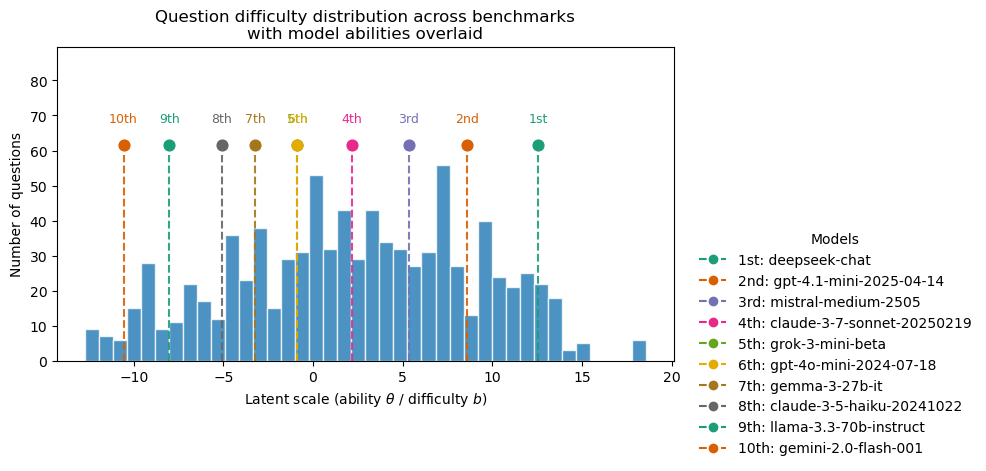

In [17]:
plot_difficulty_and_ability(model_params_arena, question_params_arena, save_path="./figures/arena_pairwise_900.pdf", save=True)

# Additional Analyses

In [18]:
def accuracy_ranking_from_static(csv_path: str) -> pd.DataFrame:
    """
    Load a static benchmark CSV and compute accuracy-based model ranking.

    Assumes the CSV has at least:
      - 'model_name'   : model identifier
      - 'judge_result' : 0/1 correctness indicator

    Returns:
      DataFrame with columns:
        - model_name
        - n_questions
        - accuracy
      sorted by accuracy (descending).
    """
    df = pd.read_csv(csv_path)

    # sanity: ensure judge_result is numeric 0/1
    df["judge_result"] = df["judge_result"].astype(float)

    ranking = (
        df.groupby("model_name")["judge_result"]
          .agg(n_questions="count", accuracy="mean")
          .reset_index()
          .sort_values("accuracy", ascending=False)
          .reset_index(drop=True)
    )

    # convert accuracy to percentage if you like
    ranking["accuracy"] = ranking["accuracy"] * 100.0

    return ranking


In [19]:
ranking_df = accuracy_ranking_from_static("./data/static_10_models.csv")
print(ranking_df)

                   model_name  n_questions  accuracy
0            grok-3-mini-beta          500      87.0
1     gpt-4.1-mini-2025-04-14          500      80.4
2            deepseek-v3-0324          500      76.4
3         mistral-medium-2505          500      65.2
4   claude-3-5-haiku-20241022          500      59.0
5                 gpt-4o-mini          500      58.8
6            gemini-2.0-flash          500      57.0
7            llama-3.3-70b-it          500      55.6
8  claude-3-7-sonnet-20250219          500      53.2
9              gemma-3-27b-it          500      36.4
